In [4]:
#!pip install fireducks

In [5]:
import fireducks.pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import cv2

In [6]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


---

## Using `CV2` & `IPython.display` To View Images
### <center> NOTICE: NOT ALL PHOTOS ARE OF THE SAME DIMENSIONS! </center>

In [7]:
img_test = cv2.imread(
    "/content/drive/MyDrive/colab_notebooks/projects/ecg/ecg_dataset/train/MI/MI(1).jpg"
)

In [8]:
img_test.shape

(1572, 2213, 3)

In [9]:
from IPython.display import Image, display

# Ensure the image values are in the range 0-255
image = (img_test * 255).astype(np.uint8)

# Convert from RGB to BGR (OpenCV uses BGR)
if image.shape[2] == 3:
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

# Save the image to a temporary file
cv2.imwrite("temp_image.png", image)

# Display the image in the notebook
display(Image(filename="temp_image.png"))

Output hidden; open in https://colab.research.google.com to view.

---

## Using `plt` To View Images

In [10]:
img_test = plt.imread(
    "/content/drive/MyDrive/colab_notebooks/projects/ecg/ecg_dataset/train/MI/MI(1).jpg"
)

In [11]:
img_test.shape

(1572, 2213, 3)

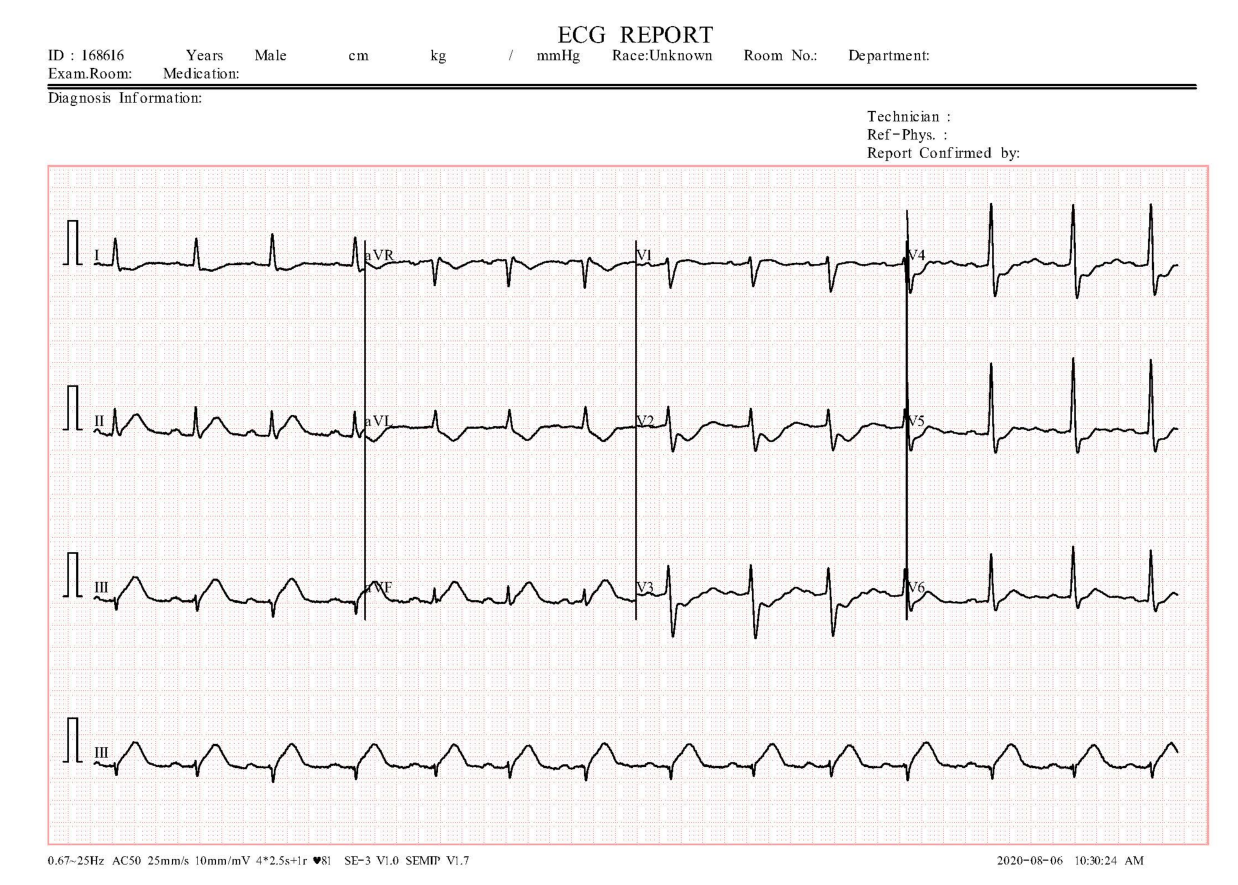

In [12]:
# Display the image
plt.figure(figsize=(15.72, 22.13), dpi=100)  # Set figure size to 224x224 pixels
plt.imshow(img_test)
plt.axis("off")  # Turn off axis labels
plt.show()

---

# Loading Data Using Pytorch With Folder Labels

In [13]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
import os

# Dataset Generation


Transformer:
1.   Crop just the ECG part of the photo
2.   Resize all photos to same dimensions
3.   **CHANGE DIMENSIONS from `(3 , height, width)` -> `(height, width, 3)`**
     * The Model will receive an image of dimensions `(H, W, 3)`


In [14]:
ECG_HEIGHT_WIDTH_RATIO = 54 / 32

IMAGE_HEIGHT = 448 * 2
IMAGE_WIDTH = int(IMAGE_HEIGHT * ECG_HEIGHT_WIDTH_RATIO)

In [15]:
from PIL import Image

"""
Class to crop out only ECG part of the image
"""


class RedRectangleCrop(object):
    def __init__(self, margin=5):
        self.margin = margin

    def __call__(self, img):
        # Convert PIL Image to OpenCV format
        open_cv_image = np.array(img.convert("RGB"))
        open_cv_image = open_cv_image[:, :, ::-1].copy()  # Convert RGB to BGR

        # Convert to HSV color space
        hsv = cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2HSV)

        # Define range of red color in HSV
        lower_red1 = np.array([0, 50, 50])
        upper_red1 = np.array([10, 255, 255])
        lower_red2 = np.array([170, 50, 50])
        upper_red2 = np.array([180, 255, 255])

        # Create a mask for red color
        mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
        mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
        mask = mask1 + mask2

        # Find contours in the mask
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            # Find the largest contour (assuming it's the rectangle we want)
            largest_contour = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(largest_contour)

            # Add margin
            x += self.margin
            y += self.margin
            w -= 2 * self.margin
            h -= 2 * self.margin

            # Ensure we don't go out of bounds
            x = max(0, x)
            y = max(0, y)
            w = min(w, open_cv_image.shape[1] - x)
            h = min(h, open_cv_image.shape[0] - y)

            # Crop the image
            cropped = open_cv_image[y : y + h, x : x + w]

            # Convert back to PIL Image
            return Image.fromarray(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
        else:
            # If no red rectangle is found, return the original image
            return img

In [16]:
class PermuteTensor:
    def __call__(self, tensor):
        return tensor.permute(1, 2, 0)

In [17]:
class GrayscaleConversion:
    def __call__(self, image):
        return image.convert("L")

In [18]:
transformer = transforms.Compose(
    [
        RedRectangleCrop(margin=5),
        transforms.Resize(
            (IMAGE_HEIGHT, IMAGE_WIDTH)
        ),  # Resize images to ecg default ratio
        GrayscaleConversion(),  # Convert to grayscale
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        PermuteTensor(),  # Permute the tensor dimensions
    ]
)

In [19]:
# # Define transforms WITH SPECIFIC NORMALIZATION
# transformer = transforms.Compose([
#     RedRectangleCrop(margin=5),
#     transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),  # Resize images to ecg default ratio
#     transforms.ToTensor(),  # Convert images to PyTorch tensors
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
# ])

In [20]:
class EcgDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    @property
    def classes(self):
        return self.data.classes

In [21]:
dataset = EcgDataset(
    data_dir="/content/drive/MyDrive/colab_notebooks/projects/ecg/ecg_dataset/test",
    transform=transformer,
)

In [22]:
len(dataset)

189

In [23]:
dataset.classes

['Abnormal_Heart_Beat', 'MI', 'MI_History', 'Normal']

In [24]:
print(f"image: {dataset[0][0]}")
print(f"image label: { dataset[0][1]}")

image: tensor([[[0.9765],
         [0.9725],
         [0.9804],
         ...,
         [0.9882],
         [0.9647],
         [0.9647]],

        [[0.9059],
         [0.9961],
         [0.9529],
         ...,
         [0.9725],
         [0.9765],
         [0.8980]],

        [[0.9059],
         [0.9922],
         [0.9647],
         ...,
         [0.9765],
         [0.9922],
         [0.8902]],

        ...,

        [[0.9961],
         [0.9922],
         [0.9922],
         ...,
         [0.9804],
         [0.9608],
         [0.9059]],

        [[0.9922],
         [0.9961],
         [0.9961],
         ...,
         [0.9882],
         [0.9725],
         [0.9647]],

        [[0.9922],
         [0.9961],
         [0.9882],
         ...,
         [0.9608],
         [0.9843],
         [0.7098]]])
image label: 0


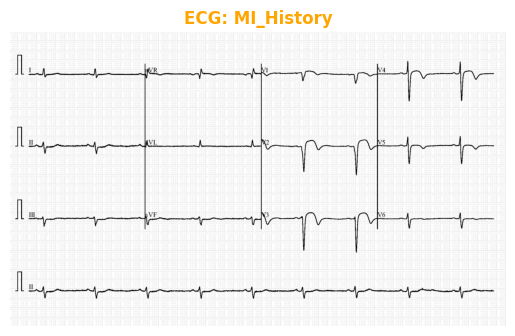

In [26]:
image, label = dataset[100]
plt.imshow(image, cmap="gray")
plt.axis("off")
plt.title(f"ECG: {dataset.classes[label]}", fontweight="bold", color="orange")
plt.show()

---

# Dataloader

In [27]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=86)

In [28]:
for images, labels in dataloader:
    print(images.shape, ",", labels.shape)
    print("\n")

    print(f"labels: {labels}")
    print("\n\n")

    for image, label in zip(images, labels.tolist()):
        print(f"Image Shape: {image.shape}")
        plt.imshow(image, cmap="gray")
        plt.axis("off")
        plt.title(f"ECG: {dataset.classes[label]}", fontweight="bold", color="orange")
        plt.show()
        print("\n")
    break

Output hidden; open in https://colab.research.google.com to view.

---

tensor(2)


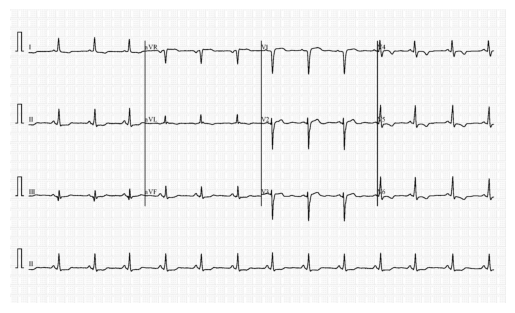

In [29]:
for images, labels in dataloader:
    for image, label in zip(images, labels):
        print(label)
        plt.imshow(image, cmap="gray")
        plt.axis("off")
        break
    break

---

# Saving The Cleaned Images To Corresponding Folders

## <u> Labels: </u>
* 0 = `/content/drive/MyDrive/colab_notebooks/projects/ecg/cleaned_dataset/train/abnormal_heartbeat`
* 1 = `/content/drive/MyDrive/colab_notebooks/projects/ecg/cleaned_dataset/train/mi`
* 2 = `/content/drive/MyDrive/colab_notebooks/projects/ecg/cleaned_dataset/train/mi_history`
* 3 = `/content/drive/MyDrive/colab_notebooks/projects/ecg/cleaned_dataset/train/normal`

In [30]:
def save_images_to_folders(dataloader, base_folder):
    label_to_folder = {0: "abnormal_heartbeat", 1: "mi", 2: "mi_history", 3: "normal"}

    # Ensure the base folder exists
    os.makedirs(base_folder, exist_ok=True)

    # Create subfolders for each label
    for folder in label_to_folder.values():
        os.makedirs(os.path.join(base_folder, folder), exist_ok=True)

    for images, labels in dataloader:
        for image, label in zip(images, labels.tolist()):
            # Convert the tensor to a numpy array and prepare for PIL
            # Remove the channel dimension and ensure it's the right datatype
            image_np = (image.squeeze().cpu().numpy() * 255).astype(np.uint8)

            # Create a PIL Image
            pil_image = Image.fromarray(image_np, mode="L")

            # Get the corresponding folder name for this label
            folder_name = label_to_folder.get(label, "unknown")

            # Generate a unique filename
            filename = f"image_{label}_{torch.rand(1).item():.6f}.png"

            # Save the image to the appropriate folder
            save_path = os.path.join(base_folder, folder_name, filename)
            pil_image.save(save_path)

    print("All images have been saved to their respective folders.")

In [31]:
base_folder = "/content/drive/MyDrive/colab_notebooks/projects/ecg/cleaned_dataset/test"

In [32]:
save_images_to_folders(dataloader=dataloader, base_folder=base_folder)

All images have been saved to their respective folders.
